The original HandEggPyBrain uses the four basic NFL team standings, Offensive Rushing, Passing, Defensive Passing, Rushing, standings, inverted 1/x, in a feed forward neural network, to predict head to head week to week matchups. Here I update it for 2015 and place it into an IPython notebook so I won't forget how it works as easily this time. :-) 

In [1]:
NUM_TEAMS=32
ROUND_TO=3

class TeamRanks():
    off_rush_rank=0
    off_rush_rel_rank=0.0
    off_pass_rank=0
    off_pass_rel_rank=0.0
    def_rush_rank=0
    def_rush_rel_rank=0.0
    def_pass_rank=0
    def_pass_rel_rank=0.0
    def __init__(self,name):
        self.name=name
    def update_stats(self):
        self.off_rush_rel_rank=round(self.off_rush_rank/NUM_TEAMS,ROUND_TO)
        self.off_pass_rel_rank=round(self.off_pass_rank/NUM_TEAMS,ROUND_TO)
        self.def_rush_rel_rank=round(self.def_rush_rank/NUM_TEAMS,ROUND_TO)
        self.def_pass_rel_rank=round(self.def_pass_rank/NUM_TEAMS,ROUND_TO)
    def unnormed_ranks(self):
        return self.off_rush_rank,self.off_pass_rank,self.def_rush_rank,self.def_pass_rank
    def stat_rankings(self):
        return self.off_rush_rel_rank,self.off_pass_rel_rank,self.def_rush_rel_rank,self.def_pass_rel_rank
import requests,json
KIMONO_API_KEY="VVBS8xfu2F8kOYpMIsl3UyDZJhjfLIAi"
NFLORYPG = '7hm4jen4'
KIMONOURL="https://www.kimonolabs.com/api/csv/%s?apikey=%s" % (NFLORYPG,KIMONO_API_KEY)
TEAMLIST=[]
RESULT = requests.get(KIMONOURL)
WORDLIST=['"index"','index',]
for row in RESULT.text.split('\n'):
    row=row.strip().split(",")
    try:
        #print(row[1],row[3])
        if "index" and '\"index\"' not in row[3] or not row[3]:
            TEAMLIST.append(TeamRanks(row[1]))
            rank=row[3].strip('"')
            rank=int(rank)
            TEAMLIST[-1].off_rush_rank=rank
    except IndexError:
        continue
        
KIMONO_API_KEY = "VVBS8xfu2F8kOYpMIsl3UyDZJhjfLIAi"
APIS={'NFLDRYPG': 'b6x3g290',
      'NFLDPYPG': '22c7y6do',
      'NFLOPYPG': 'b7f1obbk'}
API2RANKS={'NFLDRYPG':"drr",
           'NFLDPYPG':"dpr",
           'NFLOPYPG':"opr"}
for key,val in APIS.items():
    KIMONOURL="https://www.kimonolabs.com/api/csv/%s?apikey=%s" % (val,KIMONO_API_KEY)
    RESULT = requests.get(KIMONOURL)
    for row in RESULT.text.split('\n'):
        row=row.strip().split(",")
        try:
            for team in TEAMLIST:
                if team.name in row[1]:
                    if "drr" in API2RANKS[key]:
                        rank=row[3].strip('"')
                        rank=int(rank)
                        team.def_rush_rank = rank
                    elif "dpr" in API2RANKS[key]:
                        rank=row[3].strip('"')
                        rank=int(rank)
                        team.def_pass_rank = rank
                    elif "opr" in API2RANKS[key]:
                        rank=row[3].strip('"')
                        rank=int(rank)
                        team.off_pass_rank = rank
        except IndexError:
            continue

In [2]:
for team in TEAMLIST:
    print(team.name,team.off_pass_rank,team.off_rush_rank,team.def_rush_rank,team.def_pass_rank)

"New York Jets" 21 1 31 31
"Seattle Seahawks" 27 2 25 29
"Carolina Panthers" 29 3 20 17
"Atlanta Falcons" 8 4 32 4
"Green Bay Packers" 20 5 9 22
"Minnesota Vikings" 32 6 15 19
"Buffalo Bills" 28 7 29 10
"Pittsburgh Steelers" 24 8 27 7
"Tampa Bay Buccaneers" 26 9 8 28
"Cincinnati Bengals" 6 10 16 13
"Arizona Cardinals" 7 11 18 24
"St. Louis Rams" 31 12 12 23
"Chicago Bears" 25 13 6 27
"Baltimore Ravens" 11 14 23 6
"San Francisco 49ers" 30 15 13 3
"Tennessee Titans" 22 16 5 32
"Washington Redskins" 23 17 10 25
"Dallas Cowboys" 17 18 22 16
"Philadelphia Eagles" 14 19 24 14
"Kansas City Chiefs" 19 20 21 8
"New England Patriots" 2 21 11 18
"Indianapolis Colts" 13 22 14 5
"Houston Texans" 4 23 17 20
"Jacksonville Jaguars" 12 24 19 12
"Cleveland Browns" 9 25 1 15
"Miami Dolphins" 16 26 2 21
"Oakland Raiders" 15 27 30 1
"New York Giants" 10 28 26 2
"San Diego Chargers" 1 29 4 26
"Denver Broncos" 18 30 28 30
"New Orleans Saints" 3 31 3 9
"Detroit Lions" 5 32 7 11


##Training

We train the dataset on the previous week's results, using a dictionary of {'WinnerNick':'LoserNick',} based on a winner 1, loser 0, that we use to as a goal for the network.

Training on Last week's Results
Saints   1 Falcons   0 
Jets     1 Redksins  0
Steelers 1 Cardinals 0
Vikings  1 Chiefs    0
Bengals  1 Bills     0
Lions    1 Bears     0
Broncos  1 Browns    0
Texans   1 Jaguars   0
Dolphins 1 Titans    0
Panthers 1 Seahawks  0
Packers  1 Chargers  0
49ers    1 Ravens    0
Patriots 1 Colts     0
Eagles   1 Giants    0

In [3]:
LASTWEEK={'Saints':'Falcons',
          'Jets'  : 'Redskins',
          'Steelers': 'Cardinals',
          'Vikings' : 'Chiefs',
          'Bengals' : 'Bills',
          'Lions' : 'Bears',
          'Broncos' : 'Browns',
          'Texans' : 'Jaguars',
          'Dolphins': 'Titans',
          'Panthers': 'Seahawks',
          'Packers' : 'Chargers',
          '49ers' : 'Ravens',
          'Patriots':'Colts',
          'Eagles': 'Giants'}
LASTSCORES={'Saints':31,'Falcons':21,'Jets':34,'Redskins':20,'Steelers':25,'Cardinals':13,'Vikings':16,'Chiefs':10,
            'Bengals':34, 'Bills':21,'Lions':37,'Bears':34,'Broncos':26,'Browns':23,'Texans':31,'Jaguars':20,'Dolphins':38,
            'Titans':10, 'Panthers':27, 'Seahawks':23,'Packers':27,'Chargers':20,'49ers':25,'Ravens':20,'Patriots':34,
            'Colts':27,'Eagles':27,'Giants':7}

THISWEEK={'Bills':'Jaguars',
          'Buccaneers': 'Redskins',
          'Falcons' : 'Titans',
          'Saints' : 'Colts',
          'Vikings' : 'Lions',
          'Steelers' : 'Chiefs',
          'Browns': 'Rams',
          'Texans' : 'Dolphins',
          'Jets' : 'Patriots',
          'Raiders' : 'Chargers',
          'Cowboys' : 'Giants',
          'Eagles' : 'Panthers',
          'Ravens' : 'Cardinals',
          'Broncos': 'Packers'}

FeedForwardNetwork-5
   Modules:
    [<ReluLayer 'input_ranks'>, <SigmoidLayer 'hidden_calcs'>, <ReluLayer 'output_scores'>]
   Connections:
    [<FullConnection 'FullConnection-3': 'hidden_calcs' -> 'output_scores'>, <FullConnection 'FullConnection-4': 'input_ranks' -> 'hidden_calcs'>]

Ranklist:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8
2
Scores=  (0.094, 0.906, 0.625, 0.531, 0.062, 0.844, 0.781, 0.906)
Scores=  (0.594, 0.438, 0.75, 0.438, 0.875, 0.312, 0.812, 0.062)
Scores=  (0.25, 0.75, 0.844, 0.219, 0.344, 0.219, 0.562, 0.75)
Scores=  (0.656, 0.062, 0.344, 0.562, 0.688, 0.406, 0.438, 0.156)
Scores=  (0.312, 0.188, 0.5, 0.406, 0.219, 0.875, 0.906, 0.312)
Scores=  (0.938, 0.562, 0.875, 0.938, 0.781, 0.281, 0.031, 0.469)
Scores=  (1.0, 0.156, 0.219, 0.344, 0.406, 0.781, 0.188, 0.844)
Scores=  (0.719, 0.125, 0.531, 0.625, 0.75, 0.375, 0.594, 0.375)
Scores=  (0.156, 0.625, 0.281, 0.688, 0.906, 0.031, 0.125, 0.812)
Scores=  (0.969, 0.094, 0.094, 0.281, 0.125, 0.25, 1.0, 0.125)
Scores=

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS', 'StayPuft'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


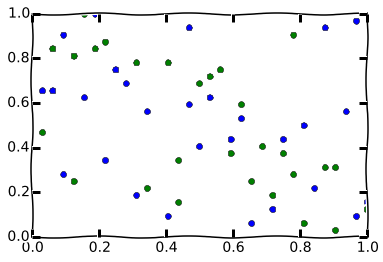

In [4]:
%matplotlib inline
import  matplotlib.pyplot as plt 
from pybrain.structure import FeedForwardNetwork,LinearLayer,SigmoidLayer,ReluLayer
from pybrain.tests.helpers import gradientCheck
from scipy import diag, arange, meshgrid, where
import numpy as np
import dill 
import array
#try to open neural network from file, if fails, init a new one
#try:
#    with open('neural-network.dill', 'rb') as f:
#         bpnet = dill.load(f)
#except:
#bpnet = algorithms.Backpropagation(
#        (4, 4, 1),
#        step=0.1,
#        verbose=False,
#        show_epoch=5000,
#        )
n=FeedForwardNetwork()
inLayer=ReluLayer(8,name='input_ranks')
HiddenLayer=SigmoidLayer(5,name='hidden_calcs')
outLayer=ReluLayer(2,name='output_scores')
n.addInputModule(inLayer)
n.addModule(HiddenLayer)
n.addOutputModule(outLayer)
from pybrain.structure import FullConnection
in_to_hidden = FullConnection(inLayer, HiddenLayer)
hidden_to_out = FullConnection(HiddenLayer, outLayer)
#nextHid_to_out = FullConnection(HiddenLayer, outLayer)
n.addConnection(in_to_hidden)
n.addConnection(hidden_to_out)
#n.addConnection(nextHid_to_out)

n.sortModules()
print(n)
np.random.seed()
ticks=arange(-1.,1.,0.1)
X, Y = meshgrid(ticks, ticks)
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets.supervised import SupervisedDataSet
for team in TEAMLIST:
    team.update_stats();
RANKLIST=[ 0.0 for x in range(8)]
print('Ranklist: ',RANKLIST)
target_data = np.array([
        [1,0]
])
ds=SupervisedDataSet(8,2)

plt.figure(1)
plt.ioff()
plt.clf()
plt.xkcd()
plt.ion()
for winner, loser in LASTWEEK.items():
    
    for team in TEAMLIST:
        if winner in team.name:
            NEWLIST=team.unnormed_ranks()
            RANKLIST=team.stat_rankings()
    for team in TEAMLIST:
        if loser in team.name:
            NEWLIST+=team.unnormed_ranks()
            RANKLIST+=team.stat_rankings()
            
    #print("NEWLIST=",NEWLIST)
    print("Scores= ",RANKLIST)
#   input_data = np.array([
#       [FIRST_TEAM.stat_rankings(),SECOND_TEAM.stat_rankings()]
#    ])
    init_input = np.array([
      NEWLIST      
    ])
    SCORELIST=[]
    
    for team,score in LASTSCORES.items(): 
        if team in winner or team is winner:
            SCORELIST.append(score)
        elif team in loser or team is loser:
            SCORELIST.append(score)
    #print(WSCORE,LSCORE)
    target_data = np.array([
        [1,0]
    ])
    plt.hold(True)
    ds.addSample(RANKLIST,[1,0])
    plt.plot(RANKLIST[0],RANKLIST[1],'bo')
    plt.plot(RANKLIST[2],RANKLIST[3],'bo')
    plt.plot(RANKLIST[4],RANKLIST[5],'go')
    plt.plot(RANKLIST[6],RANKLIST[7],'go')
    plt.draw()
    #print(input_data.indim,n.indim)
    #print(init_input,target_data,ds)
trainer=BackpropTrainer(n,ds)
#print("now training neural net on ",winner," vs",loser,end='*')
print("now training on full week's results")
trainer.trainEpochs(epochs=50)
#print(type(ds),ds)
print("Gradient check: ",gradientCheck(n),'*')
plt.show()

In [5]:
#now that network is trained, save it for later loading ...
f=open('PyBrainReLu.dill','wb')
dill.dump(n,f)
f.close()

In [6]:
net=n
for mod in net.modules:
    print("Module:", mod.name)
    if mod.paramdim > 0:
        print("--parameters:", mod.params)
    for conn in net.connections[mod]:
        print("-connection to", conn.outmod.name)
        if conn.paramdim > 0:
             print("- parameters", conn.params)
    if hasattr(net, "recurrentConns"):
        print("Recurrent connections")
        for conn in net.recurrentConns:
            print("-", conn.inmod.name, " to", conn.outmod.name)
            if conn.paramdim > 0:
                print("- parameters", conn.params)

Module: hidden_calcs
-connection to output_scores
- parameters [ 0.6602218  -0.81311595 -1.30464115  1.05896453  1.5308437   0.56033606
 -0.13310774 -0.62018628 -1.01137323  0.34829076]
Module: output_scores
Module: input_ranks
-connection to hidden_calcs
- parameters [ 1.89140163 -0.45571416  0.54663903 -0.092586    0.77202934  0.01745558
  1.15725354  0.81547119 -0.21994878 -0.09270578 -0.80148296 -0.9775486
 -0.73031532  2.15312095 -0.1768273  -0.5272756   0.82931416 -1.35595704
  0.82926751  1.32209656  0.29246129  0.50045669  1.52381323 -0.4342762
 -0.32478439 -0.02102764 -0.45890584  1.61334983 -1.51001268 -0.13440047
  1.36369649  0.25308307  0.70097425 -1.7448888  -0.18066651  0.37299552
  1.03616576 -0.10700974  1.03526021  1.05529005]


(0.875, 0.312, 0.812, 0.062, 0.562, 0.531, 0.688, 0.5)
now predicting  Cowboys 0.881  vs  Giants -0.0* total difference:  0.88071 *
(0.344, 0.219, 0.562, 0.75, 0.438, 0.344, 0.719, 0.188)
now predicting  Ravens 1.19  vs  Cardinals -0.0* total difference:  1.18978 *
(0.625, 0.594, 0.656, 0.25, 0.25, 0.75, 0.844, 0.219)
now predicting  Steelers 0.686  vs  Chiefs -0.0* total difference:  0.68582 *
(0.375, 0.969, 0.375, 0.719, 0.781, 0.281, 0.031, 0.469)
now predicting  Browns 0.838  vs  Rams -0.0* total difference:  0.83761 *
(0.906, 0.031, 0.125, 0.812, 0.844, 0.469, 0.938, 0.031)
now predicting  Raiders 1.315  vs  Chargers -0.0* total difference:  1.31489 *
(0.656, 0.062, 0.344, 0.562, 0.031, 0.656, 0.969, 0.969)
now predicting  Jets 1.391  vs  Patriots -0.0* total difference:  1.39098 *
(0.156, 0.625, 0.281, 0.688, 0.938, 0.562, 0.875, 0.938)
now predicting  Broncos 1.375  vs  Packers -0.0* total difference:  1.37503 *
(0.5, 0.688, 0.156, 1.0, 0.125, 0.25, 1.0, 0.125)
now predicting  F

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS', 'StayPuft'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


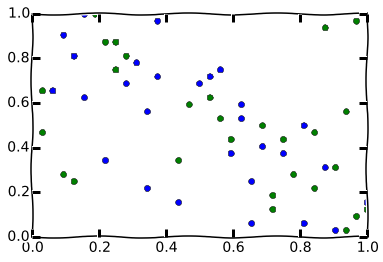

In [8]:
THISWEEK={'Bills':'Jaguars',
          'Buccaneers': 'Redskins',
          'Falcons' : 'Titans',
          'Saints' : 'Colts',
          'Vikings' : 'Lions',
          'Steelers' : 'Chiefs',
          'Browns': 'Rams',
          'Texans' : 'Dolphins',
          'Jets' : 'Patriots',
          'Raiders' : 'Chargers',
          'Cowboys' : 'Giants',
          'Eagles' : 'Panthers',
          'Ravens' : 'Cardinals',
          'Broncos': 'Packers'}
#First, update the team stats
ticks=arange(-1.,1.,0.1)
X, Y = meshgrid(ticks, ticks)
for team in TEAMLIST:
    team.update_stats()
for home, away in THISWEEK.items():
    NEWLIST=[]
    for team in TEAMLIST:
        if away in team.name:
            NEWLIST=team.stat_rankings()
    for team in TEAMLIST:
        if home in team.name:
            NEWLIST+=team.stat_rankings()
    print(NEWLIST)
    input_data = np.array(
        NEWLIST
    )        
   # print(input_data,len(input_data))
    predicted=n.activate(input_data)
    #print(predicted,predicted[0],predicted[1])
    print("now predicting ",home,round(float(predicted[0]),3)," vs ",away,round(float(predicted[1]),3),end='*')
    print(" total difference: ",round(float(predicted[0]-predicted[1]),5),'*')
    plt.figure(1)
    plt.ioff()
    #plt.clf()
    plt.hold(True)
    plt.plot(NEWLIST[0],NEWLIST[1],'bo')
    plt.plot(NEWLIST[2],NEWLIST[3],'bo')
    plt.plot(NEWLIST[4],NEWLIST[5],'go')
    plt.plot(NEWLIST[6],NEWLIST[7],'go')
   # if predicted.max()!=predicted.min():  # safety check against flat field
  #     plt.contourf(X, Y, predicted)
    plt.ion()
    plt.draw()